In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy as copy
from scipy import optimize
import torch
np.random.seed(1)
torch.random.manual_seed(1)

import sys
sys.path.append('../')  #for savo import
sys.path.append('../../machineIO/')  #for machineIO import
from savo import savo
from savo.optim import adam
from machineIO.util import plot_2D_projection, dictClass
from machineIO.objFunc import SingleTaskObjectiveFunction
from machineIO.VM import VirtualMachineIO
from machineIO import Evaluator

Failed to import 'epics'
Failed to import 'phantasy'


In [3]:
ndim = 30
nRD = 6
budget = 200
model_train_budget = 200
ninit = ndim  # number of initial ES steps to collect data for surrogate model training
noise = 1e-3
max_dx = 4e-2
lr = 2
lrES = 1

In [4]:
control_CSETs = [f'X{i}:I_CSET' for i in range(ndim)]
control_RDs   = [f'X{i}:I_RD'   for i in range(ndim)]
control_min   = -np.ones(ndim)
control_max   =  np.ones(ndim)
control_maxstep = max_dx*np.ones(ndim)
control_tols  = 1e-3*(control_max-control_min)
monitor_RDs   = [f'Y{i}:I_RD' for i in range(nRD)]
monitor_min   = 0*np.ones(nRD)
monitor_max   = 10*np.ones(nRD)

objective_PVs = monitor_RDs
composite_objective_name = 'composite_obj'

In [5]:
vmio = VirtualMachineIO(
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    monitor_RDs = monitor_RDs,
    control_min = control_min,
    control_max = control_max,
    monitor_min = monitor_min,
    monitor_max = monitor_max,
    fetch_data_time_span = 1.0
)

# obj_func

In [6]:
obj_func = SingleTaskObjectiveFunction(
    objective_PVs = monitor_RDs,
    composite_objective_name = composite_objective_name,
    custom_function = None,
    objective_goal = {PV:0 for PV in monitor_RDs}, 
    objective_weight = {PV:1 for PV in monitor_RDs},
    objective_tolerance = {PV:1 for PV in monitor_RDs},
)

In [7]:
evaluator = Evaluator(
    machineIO = vmio,
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    control_tols = control_tols,
    monitor_RDs = monitor_RDs,
    df_manipulators = [obj_func.calculate_objectives_from_df],
)

In [8]:
# control_init = evaluator.read()[control_CSETs].mean().values
control_init = np.random.rand(len(control_CSETs))*(control_max-control_min)+control_min

In [9]:
def plot_hist(history):
    fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=96)
    xaxis = np.arange(len(history['y']))
    ax[0].plot(xaxis, history['y'])
    ax[0].set_xlabel('epoch');
    ax[0].set_ylabel('objective');
    ax[1].plot(xaxis, history['cpu_time'])
    ax[1].set_xlabel('epoch');
    ax[1].set_ylabel('cpu_time');
    fig.tight_layout()

# ES

In [10]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator)
for i in range(budget):
    sv.step(lr=0,lrES=1)

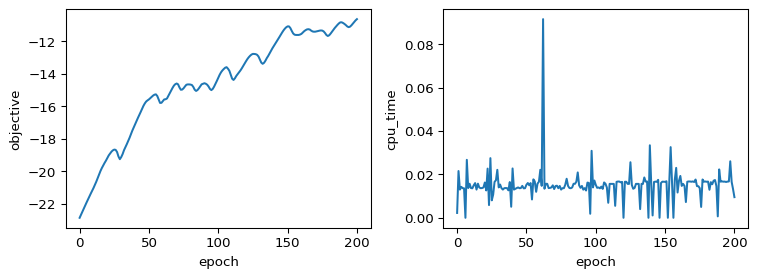

In [11]:
plot_hist(sv.history)

# ES + adamSG

In [12]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, model_train_budget=model_train_budget, optimizer=optimizer)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1)

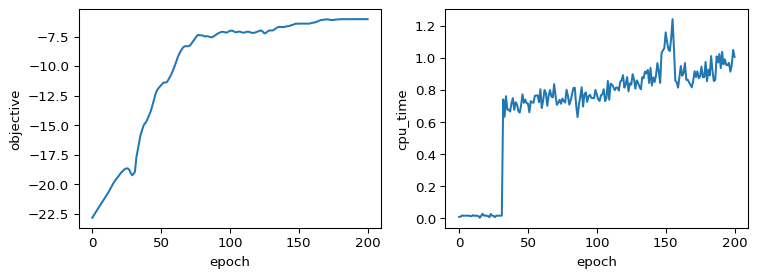

In [13]:
plot_hist(sv.history)

# ES + SG

In [14]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, model_train_budget=model_train_budget)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1)

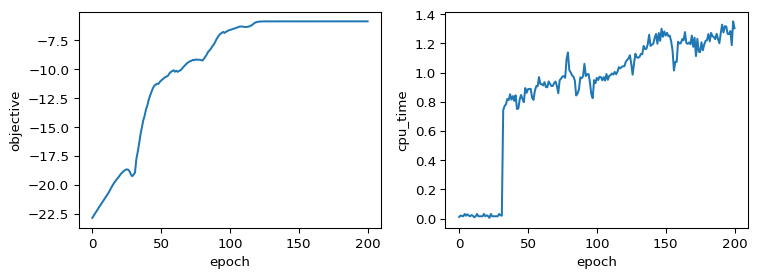

In [15]:
plot_hist(sv.history)

# ES + SG normalized grad

In [16]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, model_train_budget=model_train_budget)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1,normalize_gradient_step=True)

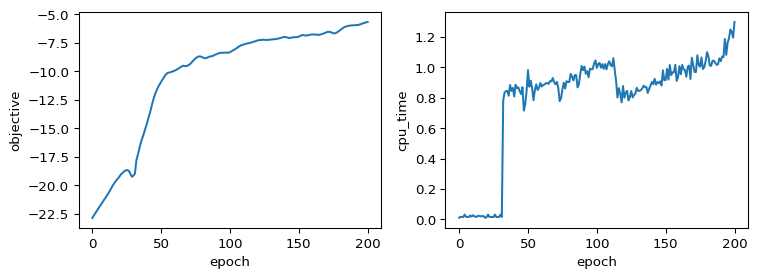

In [17]:
plot_hist(sv.history)

# ES + SG penalize_uncertain_gradient

In [18]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, model_train_budget=model_train_budget)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=1,penalize_uncertain_gradient=True)

C:\Users\HWANG\My Drive\GitHub\savo\example\..\savo\model.py:388: UserWarning: Cholesky decomposition failed. Falling back to linalg.solve().
  warnings.warn("Cholesky decomposition failed. Falling back to linalg.solve().")
C:\Users\HWANG\My Drive\GitHub\savo\example\..\savo\model.py:388: UserWarning: Cholesky decomposition failed. Falling back to linalg.solve().
  warnings.warn("Cholesky decomposition failed. Falling back to linalg.solve().")
C:\Users\HWANG\My Drive\GitHub\savo\example\..\savo\model.py:388: UserWarning: Cholesky decomposition failed. Falling back to linalg.solve().
  warnings.warn("Cholesky decomposition failed. Falling back to linalg.solve().")


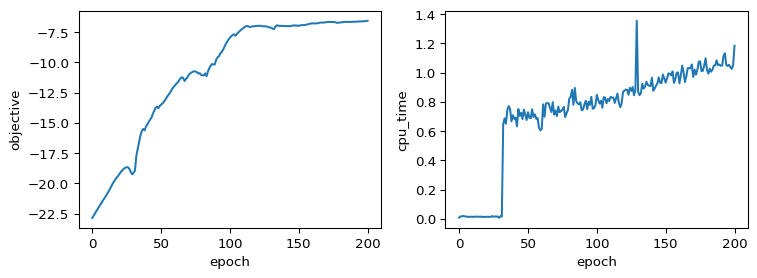

In [19]:
plot_hist(sv.history)

# SG wo ES

In [20]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, model_train_budget=model_train_budget)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=0)

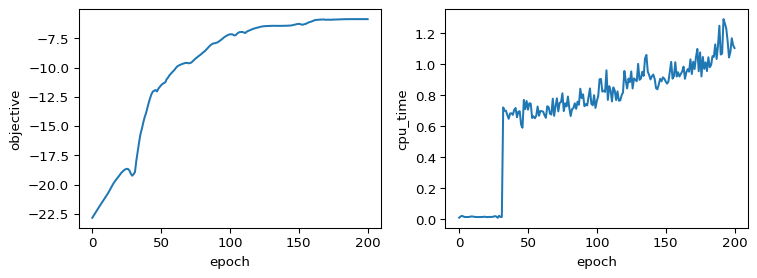

In [21]:
plot_hist(sv.history)

# adamSG wo ES

In [22]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, model_train_budget=model_train_budget, optimizer=optimizer)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=lr,lrES=0)

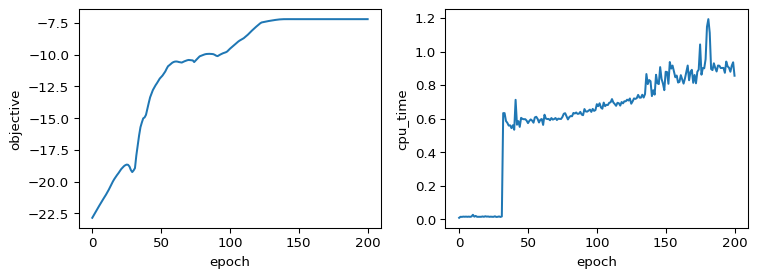

In [23]:
plot_hist(sv.history)